In [1]:
### import modules
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.patheffects as pe
import matplotlib.transforms as transforms
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter
from scipy import ndimage
from scipy.interpolate import interp1d
from scipy import interpolate
import scipy.stats
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from scipy.stats import ks_2samp, anderson_ksamp
from scipy.optimize import curve_fit
import os
import time
import h5py
import rohr_utils as ru 
import random
import six
%matplotlib widget

plt.style.use('fullpage.mplstyle')

zs, times = ru.return_zs_costimes()
times /= 1.0e9 # [Gyr]
scales = 1. / (1.+ zs)


In [2]:
os.chdir('/u/reric/Scripts/')
! pwd

/vera/u/reric/Scripts


In [4]:
def load_grpdict(infname, sim='TNG50-1'):
    result = {}
    with h5py.File('../Output/%s_subfindGRP/'%sim + infname, 'r') as f:
        for group_key in f.keys():
            result[group_key] = {}
            for dset_key in f[group_key].keys():
                if 'xray' in dset_key:
                    continue
                result[group_key][dset_key] = f[group_key][dset_key][:]
        f.close()
    
    return result

sim = 'TNG50-1'
infname = 'central_groups_subfind_%s_branches.hdf5'%sim
groups_grp_dict = load_grpdict(infname, sim)
groups_grp_dict_keys = list(groups_grp_dict.keys())
halos_snapnum099_grp_dict = load_grpdict('central_subfind_%s_branches_snapNum099.hdf5'%sim, sim)
halos_snapnum067_grp_dict = load_grpdict('central_subfind_%s_branches_snapNum067.hdf5'%sim, sim)
halos_snapnum050_grp_dict = load_grpdict('central_subfind_%s_branches_snapNum050.hdf5'%sim, sim)
halos_snapnum033_grp_dict = load_grpdict('central_subfind_%s_branches_snapNum033.hdf5'%sim, sim)

sim = 'L680n8192TNG'

infname = 'central_subfind_%s_branches.hdf5'%sim
TNGCluster_grp_dict = load_grpdict(infname, sim)

grp_dicts = [groups_grp_dict,
             halos_snapnum099_grp_dict,
             halos_snapnum067_grp_dict,
             halos_snapnum050_grp_dict,
             halos_snapnum033_grp_dict]


In [6]:
CGMColdGasMass_key = 'SubhaloCGMColdGasMass'
fCGMColdGas_key = 'SubhaloCGMColdGasFraction'

bh_mass_key = 'MainBHMass'
bh_particleID_key = 'MainBHParticleID'
BH_CumEgyInjection_RM_key = 'MainBH_CumEgyInjection_RM'
BH_RM_FirstSnap_key = 'MainBH_RM_FirstSnap'

grp_keys = ['SnapNum', 'CosmicTime', 'HostGroup_M_Crit200',
            'HostGroup_R_Crit200', 'SubhaloMass',
            'Subhalo_Mstar_Rgal', 'Subhalo_Rgal',
            'SubhaloColdGasMass', 'SubhaloHotGasMass', 'SubhaloGasMass',
            'SubhaloCGMColdGasMass', 'SubhaloCGMColdGasFraction']

Nsats_total_key = 'Nsatellites_total'
Nsats_fiducial_key = 'NSatellites_Mstar>1.0e7_fgas>0.01_dsathost<R200c'
Nsats_onlymassive_key = 'NSatellites_Mstar>1.0e9_fgas>0.01_dsathost<R200c'
Nsats_onlySF_key = 'NSatellites_Mstar>1.0e7_SF_dsathost<R200c'
Nsats_keys = [Nsats_total_key,
              Nsats_fiducial_key,
              Nsats_onlymassive_key,
              Nsats_onlySF_key]

quench_snap_flag = -99

def create_taudict(grp_dict, snaps, branches_flag=False):
    """ 
    Given the grp_dict and snaps of interest, rearrange the grp_dict
    into a 2D array of the datasets at the snaps of interest. 
    snaps should be a list of snapNums, where snapNum -99 
    is the flag to use the quenching_snap.
    Returns the tau_dict.
    """
    # input validation
    if not isinstance(snaps, (list, np.ndarray)):
        snaps = [snaps]

    tau_keys = grp_keys.copy()
    if branches_flag:
        tau_keys.extend(Nsats_keys)
                        
    tauresult = {}
    # begin loop over subhalos
    for group_index, group_key in enumerate(grp_dict):
        group = grp_dict[group_key]
        # if just starting, then initialize the dictionary 
        if group_index == 0:
            tauresult['SubfindID'] = np.zeros(len(grp_dict), dtype=int)
            tauresult['HostSubhaloGrNr'] = np.zeros(len(grp_dict), dtype=int)
            for tau_key in tau_keys:
                for snap in snaps:
                    if snap == quench_snap_flag:
                        tauresult_key = tau_key + '_snapNumQuench'
                        tauresult[tauresult_key] = np.zeros(len(grp_dict),
                                                            dtype=group[tau_key].dtype) - 1
                    else:
                        tauresult_key = tau_key + '_snapNum%03d'%snap
                        tauresult[tauresult_key] = np.zeros(len(grp_dict),
                                                            dtype=group[tau_key].dtype) - 1
                    
        tauresult['SubfindID'][group_index] = group['SubfindID'][0]
        tauresult['HostSubhaloGrNr'][group_index] = group['HostSubhaloGrNr'][0]
        # finish initializing the the result
        # assign the values at z=0, which are always the 0th element in the array
        for tau_key in tau_keys:
            for snap in snaps:
                if snap == quench_snap_flag:
                    tauresult_key = tau_key + '_snapNumQuench'
                    tau_index = group['quenching_snap'] == group['SnapNum']
                    tauresult[tauresult_key][group_index] = group[tau_key][tau_index]
                else:
                    tauresult_key = tau_key + '_snapNum%03d'%snap
                    tau_index = snap == group['SnapNum']
                    tauresult[tauresult_key][group_index] = group[tau_key][tau_index]
            # finish loop over snaps for the grp_key
        # finish grp_keys for the group
    # finish loop over the groups
    return tauresult
    

In [7]:
groups_tau_dict = create_taudict(groups_grp_dict, [99, 67, 50, 33], branches_flag=True)
halos_snapnum099_tau_dict = create_taudict(halos_snapnum099_grp_dict, 99)
halos_snapnum067_tau_dict = create_taudict(halos_snapnum067_grp_dict, 67)
halos_snapnum050_tau_dict = create_taudict(halos_snapnum050_grp_dict, 50)
halos_snapnum033_tau_dict = create_taudict(halos_snapnum033_grp_dict, 33)
TNGCluster_tau_dict = create_taudict(TNGCluster_grp_dict, [99, 67, 50, 33], branches_flag=True)


In [8]:
figsizewidth  = 6.902 # the textwidth in inches of MNRAS
figsizeratio = 9. / 16.
figsizeheight = figsizewidth * figsizeratio

outdirec = '/u/reric/Figures/ColdPast/'
sim = 'TNG50-1'
savefig = False

In [9]:
snap_tau_dicts = [halos_snapnum099_tau_dict,
                  halos_snapnum067_tau_dict,
                  halos_snapnum050_tau_dict]

snapNums = [99, 67, 50]

result1 = []
result2 = []
percentiles = [16, 50, 84]
binwidth = 0.2 # log[M200c]
for snapNum_i, snapNum in enumerate(snapNums):
    tau_dict = snap_tau_dicts[snapNum_i]

    x_key = 'HostGroup_M_Crit200_snapNum%03d'%snapNum
    y1_key = 'SubhaloCGMColdGasMass_snapNum%03d'%snapNum
    y2_key = 'SubhaloCGMColdGasFraction_snapNum%03d'%snapNum

    y1 = tau_dict[y1_key]
    mask = y1 > 0
    y1 = np.log10(y1[mask])
    x = np.log10(tau_dict[x_key][mask])
    y2 = np.log10(tau_dict[y2_key][mask])

    result1.append(ru.return2dhiststats_dict(x, y1, binwidth, percentiles=percentiles))
    result2.append(ru.return2dhiststats_dict(x, y2, binwidth, percentiles=percentiles))



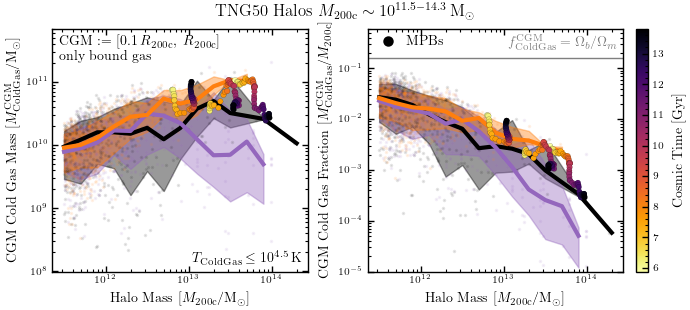

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(figsizewidth, figsizeheight * 0.8))

ax = axs[0]

colors = ['k', 'tab:purple', 'tab:orange']

for snapNum_i, snapNum in enumerate(snapNums):
    tau_dict = snap_tau_dicts[snapNum_i]
    result1_dict = result1[snapNum_i]
    color = colors[snapNum_i]

    y_50s = result1_dict[50]
    mask = y_50s > 0

    y_50s_plot = 10.**(y_50s[mask])
    y_16s_plot = 10.**(result1_dict[16][mask])
    y_84s_plot = 10.**(result1_dict[84][mask])
    x_plot = 10.**(result1_dict['bin_cents'][mask])

    data_points_kwargs = dict(alpha=0.1, ms=1, c=color, zorder=1.9)
    medians_kwargs = dict(ls='-', lw=3, marker='None', c=color, zorder=2)
    sigma_kwargs = dict(color=color, alpha=0.4)

    ax.plot(x_plot, y_50s_plot, **medians_kwargs)
    ax.fill_between(x_plot, y_16s_plot, y_84s_plot, **sigma_kwargs)

    ax.plot(tau_dict['HostGroup_M_Crit200_snapNum%03d'%snapNum], tau_dict['SubhaloCGMColdGasMass_snapNum%03d'%snapNum], **data_points_kwargs)
    
    result2_dict = result2[snapNum_i]

    y_50s_plot = 10.**(result2_dict[50][mask])
    y_16s_plot = 10.**(result2_dict[16][mask])
    y_84s_plot = 10.**(result2_dict[84][mask])
    x_plot = 10.**(result2_dict['bin_cents'][mask])

    axs[1].plot(x_plot, y_50s_plot, **medians_kwargs)
    axs[1].fill_between(x_plot, y_16s_plot, y_84s_plot, **sigma_kwargs)

    axs[1].plot(tau_dict['HostGroup_M_Crit200_snapNum%03d'%snapNum], tau_dict['SubhaloCGMColdGasFraction_snapNum%03d'%snapNum], **data_points_kwargs)
    

group_indices = [1, 6, 23]
min_snap = 50
for group_index in group_indices:
    group = groups_grp_dict[groups_grp_dict_keys[group_index]]
    SnapNum = group['SnapNum']
    subhalo_indices = group['SubfindID'] >= 0
    Subhalo_CGMCGM = group['SubhaloCGMColdGasMass']
    mask = ((SnapNum >= min_snap) & (subhalo_indices) & (Subhalo_CGMCGM > 0))

    plot_every = -1

    x = group['HostGroup_M_Crit200'][mask][::plot_every]
    y1 = Subhalo_CGMCGM[mask][::plot_every]
    y2 = group['SubhaloCGMColdGasFraction'][mask][::plot_every]
    c = group['CosmicTime'][mask][::plot_every]

    sc_kwargs = dict(c=c, cmap='inferno_r', zorder=3, s=16, edgecolors='black', linewidths=0.1)

    sc = ax.scatter(x, y1, **sc_kwargs)
    sc = axs[1].scatter(x, y2, **sc_kwargs)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(9.9e7, 7.0e11)

ax.set_xlabel(r'Halo Mass $[M_{\rm 200c} / {\rm M_\odot}]$')
ax.set_ylabel(r'CGM Cold Gas Mass $[M_{\rm ColdGas}^{\rm CGM} / {\rm M_\odot}]$')

text = (r'CGM := [$0.1\,R_{\rm 200c},\ R_{\rm 200c}$]' + '\n'
        'only bound gas')
ax.text(0.025, 0.975, text, ha='left', va='top', transform=ax.transAxes, ma='left')
ax.text(0.975, 0.025, r'$T_{\rm ColdGas} \leq 10^{4.5}\, {\rm K}$', ha='right', va='bottom', transform=ax.transAxes)

ax = axs[1]

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'Halo Mass $[M_{\rm 200c} / {\rm M_\odot}]$')
ax.set_ylabel(r'CGM Cold Gas Fraction $[M_{\rm ColdGas}^{\rm CGM} / M_{\rm 200c}]$')

ax.plot([], [], 'o', label=r'MPBs')
ax.legend(loc='upper left')

omega_b0 = 0.0486
omega_m0 = 0.3089
ax.axhline(omega_b0 / omega_m0, ls='-', lw=1, zorder=1, marker='None', c='tab:gray')
ax.set_ylim(1.0e-5, 6.0e-1)
ax.text(0.975, 0.975, r'$f_{\rm ColdGas}^{\rm CGM} = \Omega_b / \Omega_m$', ha='right', va='top',
        transform=ax.transAxes, c='tab:gray')

cbar = fig.colorbar(sc, ax=ax, label=r'Cosmic Time [Gyr]')

fig.suptitle(r'TNG50 Halos $M_{\rm 200c} \sim 10^{11.5-14.3}\, {\rm M_\odot}$')

outfname = '%s_CGMCGM-CGMCGf_M200c_allhalos.pdf'%sim
if savefig:
    fig.savefig(outdirec + outfname, bbox_inches='tight')



In [11]:
SnapNums = groups_grp_dict[groups_grp_dict_keys[0]]['SnapNum']


def return_stacked_dict(grp_dict, grp_dict_keys, xdset_key='SnapNum', ydset_key=CGMColdGasMass_key,
                        return_all_profiles=False, return_color_dset=False):
    """
    Given the grp_dict_keys and the implicit grp_dict, stack the ydset_key for all of the
    keys at xdset_key. Optionally returns all profiles and a color dset.
    """
    group0 = grp_dict[grp_dict_keys[0]]
        
    result_dict = {}
 
    # initalize the outputs
    result_dict[50] = np.zeros((len(grp_dict_keys), len(SnapNums)), dtype=group0[ydset_key].dtype) - 1.
    result_dict[16] = result_dict[50].copy()
    result_dict[84] = result_dict[50].copy()  
    result = np.zeros((len(grp_dict_keys), len(SnapNums)), dtype=group0[ydset_key].dtype) - 1.

    if return_color_dset:
        if return_color_dset in group0.keys():
            color_dset = np.zeros(len(grp_dict_keys), dtype=group0[return_color_dset].dtype) - 1
        else:
            print('Error return_color_dset %s not available in'%return_color_dset, group0.keys())
            raise ValueError

    for index, grp_dict_key in enumerate(grp_dict_keys):
        group = grp_dict[grp_dict_key]

        subhalo_indices = group['SubfindID'] >= 0
        redshift = group['Redshift'][subhalo_indices]
        
        xdset = group[xdset_key][subhalo_indices]
        ydset = group[ydset_key][subhalo_indices]
        mask = (ydset > 0) & (redshift < 3.1)

        # smooth over big jumps
        y_rm = ru.RunningMedian(ydset[mask], 3)

        ydset_func = interp1d(xdset[mask], y_rm, bounds_error=False, fill_value=0)
        result[index,:] = ydset_func(SnapNums)

        if return_color_dset:
            # assumes value of interest is at z=0, index, 0
            color_dset[index] = group[return_color_dset][0]
        
    # finish loop of indices, save final results
    result = np.ma.masked_values(result, -1)
    
    result_dict[50] = np.median(result, axis=0)
    result_dict[16] = np.percentile(result, 16, axis=0)
    result_dict[84] = np.percentile(result, 84, axis=0) 
    
    if return_all_profiles:
        if return_color_dset:
            return result_dict, result, color_dset
        else:
            return result_dict, result
    else:
        if return_color_dset:
            return result_dict, color_dset
        else:
            return result_dict
        
def add_redshift_sincez2(ax, label=True, axislabel_kwargs=dict()):
    """
    For a given x axis, add redshift since z=2 to the top x-axis. 
    Optionally label the axis + tick marks.
    Returns ax
    """
    ticks_SnapNum = [33, 40, 50, 59, 67, 78, 84, 91, 99]
    ticks_costime = times[ticks_SnapNum]
    ticks_labels = ['2', '1.5', '1', '0.7', '0.5', '0.3', '0.2', '0.1', '0']

    xlolim = ru.floor_to_value(times[np.argmin(abs(zs - 2.5))], 0.1)
    xhilim = ru.ceil_to_value(times[np.argmin(abs(zs - 0.0))], 0.1)
    xhilim = 14.1

    ax.set_xlim(xlolim, xhilim)

    redshift_ax = ax.twiny()
    redshift_ax.set_xlim(ax.get_xlim())
    redshift_ax.set_xticks(ticks_costime)
    redshift_ax.tick_params(axis='both', which='minor', top=False)
    
    yscale = ax.get_yscale()
    if yscale == 'log':
        locmin = mpl.ticker.LogLocator(subs=(0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9))
        ax.yaxis.set_minor_locator(locmin)
        #ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

    if label:
        redshift_ax.set_xlabel(r'Redshift', **axislabel_kwargs)
        redshift_ax.set_xticklabels(ticks_labels)
    else:
        redshift_ax.set_xticklabels([])
        
    return ax


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


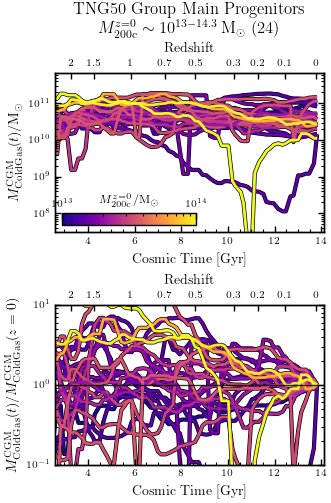

In [12]:
result_dict, result, color_dset = return_stacked_dict(groups_grp_dict, groups_grp_dict_keys, 
                                                      return_all_profiles=True, return_color_dset='HostGroup_M_Crit200')

ys = []
for row in range(result.shape[0]):
    ys.append(result[row])
xs = [groups_grp_dict[groups_grp_dict_keys[0]]['CosmicTime'].tolist()] * len(ys)
c = color_dset.tolist()

figsizewidth_column = (244. / 508.) * figsizewidth
figsizeheight_column = figsizewidth_column * figsizeratio

fig, axs = plt.subplots(2, 1, figsize=(figsizewidth_column, figsizeheight_column * 2.7))
ax = axs[0]
ax.set_yscale('log')
ax.set_ylabel(r'$M_{\rm ColdGas}^{\rm CGM}(t) / {\rm M_\odot}$')
ax.set_xlabel(r'Cosmic Time [Gyr]')

lc_kwargs = dict(cmap='plasma', norm=mpl.colors.LogNorm(vmin=10.**(13), vmax=10.**(14)),
                 path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])

lc = ru.multiline(xs[::-1], ys[::-1], c[::-1], ax=ax, **lc_kwargs)
ax.set_xlim(2.75, 14.05)
ax.set_ylim(3e7, 7.0e11)
ax = add_redshift_sincez2(ax)

cax = inset_axes(ax, width='50%', height='7.5%', loc='lower left')
cbar = plt.colorbar(lc, cax=cax, orientation='horizontal')
cbar.set_label(r'$M_{\rm 200c}^{z=0} / {\rm M_\odot}$', labelpad=-3, fontsize='small')
cbar.ax.tick_params(labelsize='x-small')
cax.xaxis.set_label_position('top')
cax.xaxis.set_ticks_position('top')

ax = axs[1]

ys_norm = []
for y in ys:
    ys_norm.append(y / y[0])

lc = ru.multiline(xs[::-1], ys_norm[::-1], c[::-1], ax=ax, **lc_kwargs)
ax.set_xlim(axs[0].get_xlim())
ax.set_ylim(1.0e-1, 1.0e1)
ax.set_yscale('log')
ax.set_ylabel(r'$M_{\rm ColdGas}^{\rm CGM}(t) / M_{\rm ColdGas}^{\rm CGM}(z=0)$')
ax.set_xlabel(r'Cosmic Time [Gyr]')
ax = add_redshift_sincez2(ax, label=True)
ax.axhline(1.0, ls='-', marker='None', zorder=3, lw=1, c='k', alpha=0.8)

axs[0].set_title('TNG50 Group Main Progenitors \n' + r'$M_{\rm 200c}^{z=0} \sim 10^{13-14.3}\, {\rm M_\odot}$ (%d)'%len(xs))

fname = '%s_CGMCGM-CGMCGMt-CGMCGMz0_CosmicTime_onlygroups.pdf'%sim
if savefig:
    fig.savefig(outdirec + fname, bbox_inches='tight')


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


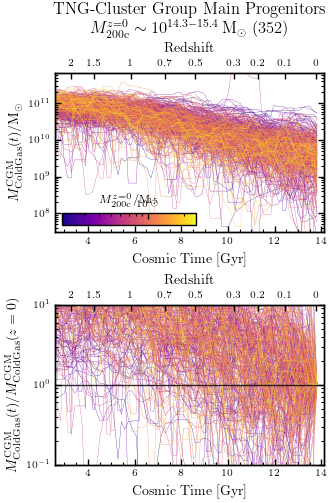

In [13]:

result_dict, result, color_dset = return_stacked_dict(TNGCluster_grp_dict, list(TNGCluster_grp_dict.keys()), 
                                                      return_all_profiles=True, return_color_dset='HostGroup_M_Crit200')

ys = []
for row in range(result.shape[0]):
    ys.append(result[row])
xs = [groups_grp_dict[groups_grp_dict_keys[0]]['CosmicTime'].tolist()] * len(ys)
c = color_dset.tolist()

figsizewidth_column = (244. / 508.) * figsizewidth
figsizeheight_column = figsizewidth_column * figsizeratio

fig, axs = plt.subplots(2, 1, figsize=(figsizewidth_column, figsizeheight_column * 2.7))
ax = axs[0]
ax.set_yscale('log')
ax.set_ylabel(r'$M_{\rm ColdGas}^{\rm CGM}(t) / {\rm M_\odot}$')
ax.set_xlabel(r'Cosmic Time [Gyr]')

lc_kwargs = dict(cmap='plasma', linewidths=0.2, norm=mpl.colors.LogNorm(vmin=10.**(14.3), vmax=10.**(15.4)))
                 #path_effects=[pe.Stroke(linewidth=0.5, foreground='k'), pe.Normal()])

lc = ru.multiline(xs[::-1], ys[::-1], c[::-1], ax=ax, **lc_kwargs)
ax.set_xlim(2.75, 14.05)
ax.set_ylim(3e7, 7.0e11)
ax = add_redshift_sincez2(ax)

cax = inset_axes(ax, width='50%', height='7.5%', loc='lower left')
cbar = plt.colorbar(lc, cax=cax, orientation='horizontal')
cbar.set_label(r'$M_{\rm 200c}^{z=0} / {\rm M_\odot}$', labelpad=-3, fontsize='small')
cbar.ax.tick_params(labelsize='x-small')
cax.xaxis.set_label_position('top')
cax.xaxis.set_ticks_position('top')

ax = axs[1]

ys_norm = []
for y in ys:
    ys_norm.append(y / y[0])

lc = ru.multiline(xs[::-1], ys_norm[::-1], c[::-1], ax=ax, **lc_kwargs)
ax.set_xlim(axs[0].get_xlim())
ax.set_ylim(1.0e-1, 1.0e1)
ax.set_yscale('log')
ax.set_ylabel(r'$M_{\rm ColdGas}^{\rm CGM}(t) / M_{\rm ColdGas}^{\rm CGM}(z=0)$')
ax.set_xlabel(r'Cosmic Time [Gyr]')
ax = add_redshift_sincez2(ax, label=True)
ax.axhline(1.0, ls='-', marker='None', zorder=3, lw=1, c='k', alpha=0.8)

axs[0].set_title('TNG-Cluster Group Main Progenitors \n' + r'$M_{\rm 200c}^{z=0} \sim 10^{14.3-15.4}\, {\rm M_\odot}$ (%d)'%len(xs))

fname = '%s_CGMCGM-CGMCGMt-CGMCGMz0_CosmicTime_onlygroups.pdf'%'TNG-Cluster'
if savefig:
    fig.savefig(outdirec + fname, bbox_inches='tight')


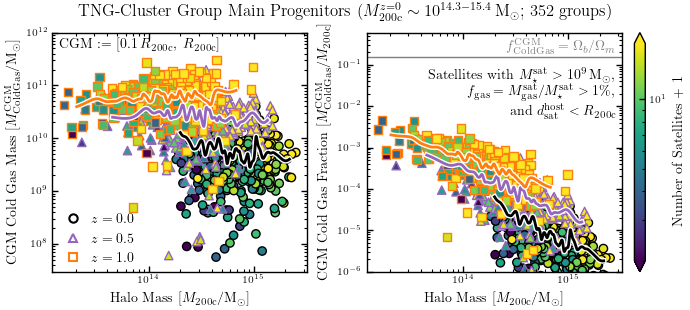

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(figsizewidth, figsizeheight * 0.8))

ax = axs[0]

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(3.0e7, 1.0e12)

ax.set_xlabel(r'Halo Mass $[M_{\rm 200c} / {\rm M_\odot}]$')
ax.set_ylabel(r'CGM Cold Gas Mass $[M_{\rm ColdGas}^{\rm CGM} / {\rm M_\odot}]$')

ax.text(0.025, 0.975, r'CGM := [$0.1\,R_{\rm 200c},\ R_{\rm 200c}$]', ha='left', va='top', transform=ax.transAxes)

ax = axs[1]
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'Halo Mass $[M_{\rm 200c} / {\rm M_\odot}]$')
ax.set_ylabel(r'CGM Cold Gas Fraction $[M_{\rm ColdGas}^{\rm CGM} / M_{\rm 200c}]$')

omega_b0 = 0.0486
omega_m0 = 0.3089
ax.axhline(omega_b0 / omega_m0, ls='-', lw=1, zorder=1, marker='None', c='tab:gray')
ax.set_ylim(1.0e-6, 6.0e-1)
ax.text(0.975, 0.975, r'$f_{\rm ColdGas}^{\rm CGM} = \Omega_b / \Omega_m$', ha='right', va='top',
        transform=ax.transAxes, c='tab:gray')

text = (r'Satellites with $M_\star^{\rm sat} > 10^9\, {\rm M_\odot}$,' + '\n' +
        r'$f_{\rm gas} = M_{\rm gas}^{\rm sat} / M_\star^{\rm sat} > 1\%$,' + '\n' + 
        r'and $d_{\rm sat}^{\rm host} < R_{\rm 200c}$')

ax.text(0.975, 0.85, text, ha='right', va='top', ma='right', transform=ax.transAxes)


markers = ['o', '^', 's']
edgecolors = colors
redshifts = [0, 0.5, 1.0]
c = TNGCluster_tau_dict[Nsats_onlymassive_key+'_snapNum%03d'%99]
sc_kwargs = dict(norm=mpl.colors.LogNorm(vmin=np.percentile(c,5), vmax=np.percentile(c,95)))
for snapNum_i, snapNum in enumerate(snapNums): 
    x_key = 'HostGroup_M_Crit200_snapNum%03d'%snapNum
    y1_key = 'SubhaloCGMColdGasMass_snapNum%03d'%snapNum
    y2_key = 'SubhaloCGMColdGasFraction_snapNum%03d'%snapNum
    c = TNGCluster_tau_dict[Nsats_onlymassive_key+'_snapNum%03d'%snapNum] + 1
    x = TNGCluster_tau_dict[x_key]
    sc = axs[0].scatter(x, TNGCluster_tau_dict[y1_key], marker=markers[snapNum_i], edgecolors=edgecolors[snapNum_i], c=c, **sc_kwargs)
    sc = axs[1].scatter(x, TNGCluster_tau_dict[y2_key], marker=markers[snapNum_i], edgecolors=edgecolors[snapNum_i], c=c, **sc_kwargs)

    order = np.argsort(x)
    sigma = 5
    x_g1d = ndimage.gaussian_filter1d(x[order], sigma)
    y1_g1d = ndimage.gaussian_filter1d(TNGCluster_tau_dict[y1_key][order], sigma)
    y2_g1d = ndimage.gaussian_filter1d(TNGCluster_tau_dict[y2_key][order], sigma)

    smooth_kwargs = dict(marker='None', ls='-', path_effects=[pe.Stroke(linewidth=4, foreground='white'), pe.Normal()])
    axs[0].plot(x_g1d, y1_g1d, c=colors[snapNum_i], **smooth_kwargs)
    axs[1].plot(x_g1d, y2_g1d, c=colors[snapNum_i], **smooth_kwargs)

    axs[0].plot([], [], marker=markers[snapNum_i], label=r'$z = %.1f$'%redshifts[snapNum_i], fillstyle='none', mec=edgecolors[snapNum_i])

    continue

axs[0].legend(loc = 'lower left')

fig.suptitle(r'TNG-Cluster Group Main Progenitors ($M_{\rm 200c}^{z=0} \sim 10^{14.3-15.4}\, {\rm M_\odot}$; %d groups)'%x.size)

cbar = fig.colorbar(sc, ax=ax, label=r'Number of Satellites + 1', extend='both')

outfname = '%s_CGMCGM-CGMCGf_M200c_Nsatellties-onlymassive_onlygroups.pdf'%'TNG-Cluster'
if savefig:
    fig.savefig(outdirec + outfname, bbox_inches='tight')


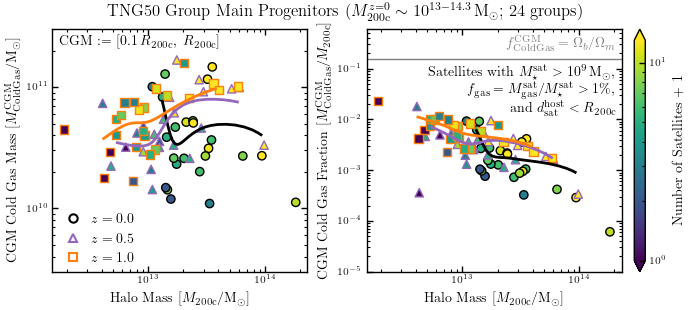

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(figsizewidth, figsizeheight * 0.8))

ax = axs[0]

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(3.0e9, 3.0e11)

ax.set_xlabel(r'Halo Mass $[M_{\rm 200c} / {\rm M_\odot}]$')
ax.set_ylabel(r'CGM Cold Gas Mass $[M_{\rm ColdGas}^{\rm CGM} / {\rm M_\odot}]$')

ax.text(0.025, 0.975, r'CGM := [$0.1\,R_{\rm 200c},\ R_{\rm 200c}$]', ha='left', va='top', transform=ax.transAxes)

ax = axs[1]
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'Halo Mass $[M_{\rm 200c} / {\rm M_\odot}]$')
ax.set_ylabel(r'CGM Cold Gas Fraction $[M_{\rm ColdGas}^{\rm CGM} / M_{\rm 200c}]$')

omega_b0 = 0.0486
omega_m0 = 0.3089
ax.axhline(omega_b0 / omega_m0, ls='-', lw=1, zorder=1, marker='None', c='tab:gray')
ax.set_ylim(1.0e-5, 6.0e-1)
ax.text(0.975, 0.975, r'$f_{\rm ColdGas}^{\rm CGM} = \Omega_b / \Omega_m$', ha='right', va='top',
        transform=ax.transAxes, c='tab:gray')

text = (r'Satellites with $M_\star^{\rm sat} > 10^9\, {\rm M_\odot}$,' + '\n' +
        r'$f_{\rm gas} = M_{\rm gas}^{\rm sat} / M_\star^{\rm sat} > 1\%$,' + '\n' + 
        r'and $d_{\rm sat}^{\rm host} < R_{\rm 200c}$')

ax.text(0.975, 0.85, text, ha='right', va='top', ma='right', transform=ax.transAxes)


markers = ['o', '^', 's']
edgecolors = colors
redshifts = [0, 0.5, 1.0]
c = groups_tau_dict[Nsats_onlymassive_key+'_snapNum%03d'%99]
sc_kwargs = dict(norm=mpl.colors.LogNorm(vmin=1, vmax=np.percentile(c,95)))
for snapNum_i, snapNum in enumerate(snapNums): 
    x_key = 'HostGroup_M_Crit200_snapNum%03d'%snapNum
    y1_key = 'SubhaloCGMColdGasMass_snapNum%03d'%snapNum
    y2_key = 'SubhaloCGMColdGasFraction_snapNum%03d'%snapNum
    c = groups_tau_dict[Nsats_onlymassive_key+'_snapNum%03d'%snapNum] + 1
    x = groups_tau_dict[x_key]
    sc = axs[0].scatter(x, groups_tau_dict[y1_key], marker=markers[snapNum_i], edgecolors=edgecolors[snapNum_i], c=c, **sc_kwargs)
    sc = axs[1].scatter(x, groups_tau_dict[y2_key], marker=markers[snapNum_i], edgecolors=edgecolors[snapNum_i], c=c, **sc_kwargs)

    order = np.argsort(x)
    sigma = 3
    x_g1d = ndimage.gaussian_filter1d(x[order], sigma)
    y1_g1d = ndimage.gaussian_filter1d(groups_tau_dict[y1_key][order], sigma)
    y2_g1d = ndimage.gaussian_filter1d(groups_tau_dict[y2_key][order], sigma)

    smooth_kwargs = dict(marker='None', ls='-')
    axs[0].plot(x_g1d, y1_g1d, c=colors[snapNum_i], **smooth_kwargs)
    axs[1].plot(x_g1d, y2_g1d, c=colors[snapNum_i], **smooth_kwargs)

    axs[0].plot([], [], marker=markers[snapNum_i], label=r'$z = %.1f$'%redshifts[snapNum_i], fillstyle='none', mec=edgecolors[snapNum_i])

    continue

axs[0].legend(loc = 'lower left')

fig.suptitle(r'TNG50 Group Main Progenitors ($M_{\rm 200c}^{z=0} \sim 10^{13-14.3}\, {\rm M_\odot}$; %d groups)'%x.size)

cbar = fig.colorbar(sc, ax=ax, label=r'Number of Satellites + 1', extend='both')

outfname = '%s_CGMCGM-CGMCGf_M200c_Nsatellties-onlymassive_onlygroups.pdf'%sim
if savefig:
    fig.savefig(outdirec + outfname, bbox_inches='tight')



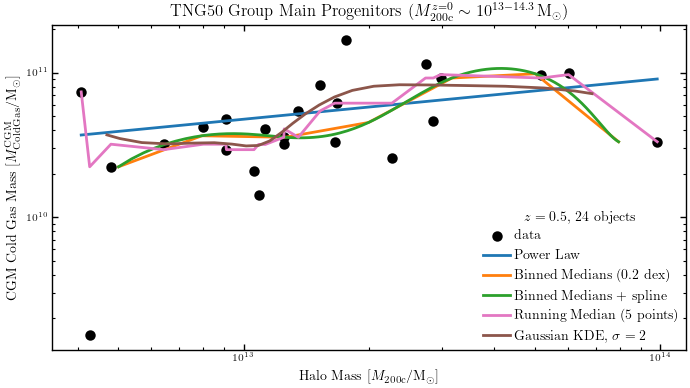

In [16]:
# consider different ways to show statistical trends
x_key = 'HostGroup_M_Crit200_snapNum%03d'%67
y1_key = 'SubhaloCGMColdGasMass_snapNum%03d'%67

x = groups_tau_dict[x_key]
y = groups_tau_dict[y1_key]

def power_law(x, slope, norm):
    return norm * x**slope

popt, pcov = curve_fit(power_law, x, y)

bin_cents, bin_meds, bin_16s, bin_84s = ru.return2dhiststats(np.log10(x), np.log10(y), binwidth)

N_smooth = 200

x_bin = 10.**(bin_cents)
y50s_bin = 10.**(bin_meds)
x_smooth = np.linspace(x_bin.min(), x_bin.max(), N_smooth)
tck = interpolate.splrep(x_bin, y50s_bin)
y50s_smooth = interpolate.splev(x_smooth, tck)

argsort = np.argsort(x)
N_RM = 5
y_RM = ru.RunningMedian(y[argsort], N_RM)

sigma = 2
x_g1d = ndimage.gaussian_filter1d(x[argsort], sigma)
y_g1d = ndimage.gaussian_filter1d(y[argsort], sigma)

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Halo Mass $[M_{\rm 200c} / {\rm M_\odot}]$')
ax.set_ylabel(r'CGM Cold Gas Mass $[M_{\rm ColdGas}^{\rm CGM} / {\rm M_\odot}]$')

# plot data
ax.plot(x, y, label=r'data')

# plot smoothed data
smooth_kwargs = dict(marker='None', ls='-')
x_plot = [x.min(), x.max()]
ax.plot(x_plot, power_law(x_plot, *popt), label=r'Power Law', **smooth_kwargs)
ax.plot(x_bin, y50s_bin, label=r'Binned Medians (%.1f dex)'%binwidth, **smooth_kwargs)
ax.plot(x_smooth, y50s_smooth, label=r'Binned Medians + spline', **smooth_kwargs)
ax.plot(x[argsort], y_RM, label=r'Running Median (%d points)'%N_RM, **smooth_kwargs)
ax.plot(x_g1d, y_g1d, label=r'Gaussian KDE, $\sigma=%d$'%sigma, **smooth_kwargs)

ax.set_title(r'TNG50 Group Main Progenitors ($M_{\rm 200c}^{z=0} \sim 10^{13-14.3}\, {\rm M_\odot}$)')

ax.legend(title=r'$z=0.5$, %d objects'%x.size)

outfname = '%s_CGMCGM_M200c_only_groups_smoothingmethods.pdf'%sim
if savefig:
    fig.savefig(outdirec + outfname, bbox_inches='tight')

In [20]:

sim = 'TNG50-1'
basePath = ru.ret_basePath(sim)
bh_ptn = il.util.partTypeNum('bh')
bh_mass_key = 'MainBHMass'
bh_particleID_key = 'MainBHParticleID'
BH_CumEgyInjection_RM_key = 'MainBH_CumEgyInjection_RM'
BH_RM_FirstSnap_key = 'MainBH_RM_FirstSnap'
h = 0.6774
MsunInGram = 1.988e33 # Msun -> g
GyrInSec = 3.154e16 # Gyr -> s
KpcInCm = 3.086e21 # Kpc -> cm